In [56]:
from google.colab import drive
drive.mount('/gdrive')
!mkdir /sets
!cp /gdrive/My\ Drive/franklin/sets/raw/lesquare_NECTAR_20190518.zip /sets/lesquare_NECTAR_20190518.zip
!unzip '/sets/*.zip' -d /sets/

from keras.models import load_model
from sklearn.metrics import log_loss, accuracy_score
import os
import numpy as np 

!git clone --single-branch --branch raph https://github.com/augustin-barillec/tortue-rapide.git
!cp tortue-rapide/franklin_gym/utils.py /content/
from utils import newtub_to_array

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
mkdir: cannot create directory ‘/sets’: File exists
Archive:  /sets/lesquare_NECTAR_20190518.zip
replace /sets/lesquare_NECTAR_20190518/3854_-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
fatal: destination path 'tortue-rapide' already exists and is not an empty directory.


In [0]:
'''Compute la loss sur le dataset NECTAR pour chaque modèle présent dans le drive'''

n_decision = '3'
x, y = newtub_to_array('/sets/lesquare_NECTAR_20190518/', n_class=3)

for model_name in os.listdir('/gdrive/My Drive/franklin/models'):
  try:
    model = load_model('/gdrive/My Drive/franklin/models/' + model_name)
    if n_decision != model_name[0]:
      x, y = newtub_to_array('/sets/lesquare_NECTAR_20190518/', n_class=int(model_name[0]))
      n_decision = model_name[0]
    y_hat = model.predict(x/255-.5)
    y_hat_pred = np.zeros((y.shape))
    y_hat_pred[np.arange(y.shape[0]), np.argmax(y_hat, axis=1)] = 1 
    
    print('{} : loss = {}, acc = {}'.format(model_name, round(log_loss(y, y_hat), 5), round(accuracy_score(y, y_hat_pred), 4)))
  except (OSError, ValueError) as e:
    print('{} : error {}'.format(model_name, type(e)))
    pass

deprecated : error <class 'OSError'>
3-first_try_20190515.hdf5 : loss = 1.29649, acc = 0.75
3-second_try_20190515.hdf5 : loss = 0.6767, acc = 0.7292
3-vgg162_20190514.hdf5 : error <class 'ValueError'>
all_data_20190518.hdf5 : error <class 'ValueError'>
selected_20190518.hdf5 : error <class 'ValueError'>
3-first_try_polished.hdf5 : loss = 0.98021, acc = 0.8125
5-medley_20190518.hdf5 : loss = 1.10399, acc = 0.5625
5-medley_augmented_20190518.hdf5 : loss = 0.688, acc = 0.7708
5-medly_wi_race_20190518.hdf5 : loss = 0.9804, acc = 0.7917
3-all_data_overfited_noflip_20190518.hdf5 : loss = 0.69225, acc = 0.8958
3-all_data_overfited_20190518.hdf5 : loss = 0.51145, acc = 0.8958
3-selected_overfited_20190518.hdf5 : loss = 0.23242, acc = 0.8958
3-selected_polished_20190518.hdf5 : loss = 0.98021, acc = 0.8125
5-only_race_20190518.hdf5 : loss = 0.62657, acc = 0.875
5-serious_limited_20190523.hdf5 : loss = 1.52988, acc = 0.2083
5-serious_20190523.hdf5 : loss = 1.49188, acc = 0.2292
5-all_but_flip_201

In [0]:
from sklearn.metrics import log_loss
log_loss(np.array([[0, 1], [1, 0]]),  # doctest: +ELLIPSIS
          np.array([[.1, .9], [.9, .1]]))

0.10536051565782628

In [0]:
n_decision = '3'
x, y = newtub_to_array('/sets/lesquare_NECTAR_20190518/', n_class=3)

In [101]:
model = load_model('/gdrive/My Drive/franklin/models/3-second_try_20190515.hdf5')

y_hat = model.predict(x/255-.5)
yhat_pred = np.zeros((y.shape))
yhat_pred[np.arange(y.shape[0]), np.argmax(y_hat, axis=1)] = 1

0.6767013017670251

In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 52, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 24, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 11, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 9, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1728)              0         
__________

In [102]:
wrong_samples = [r for y, yy, r in zip(yhat_pred, y, range(len(y))) if not np.array_equal(y, yy)]
wrong_samples

[4, 9, 13, 17, 18, 20, 22, 25, 27, 34, 36, 38, 46]

Vizualize

In [0]:
import keras.backend as K
import cv2 
import matplotlib.pyplot as plt

def viz_layer_output(img, layer_idx, pred_idx, model, crop_top=0, crop_bottom=0):
  'Vizualize specific areas of the input image that trigger the network decision'
  
  # compute prediction for specific image
  pred = model.predict(img.reshape((1,)+ img.shape)/255-.5)
  
  
  output = model.output[:, pred_idx]  
  last_conv_layer = model.layers[layer_idx]
  
  grads = K.gradients(output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  
  pooled_grads_value, conv_layer_output_value = iterate([img.reshape((1,)+ img.shape)/255-.5])
    
  n_filters = conv_layer_output_value.shape[2]

  for i in range(n_filters):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  img = img/255
  img = img.astype(np.float32)
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  added_image = cv2.addWeighted(gray_img, 0.5, heatmap, 0.1, 0)
  
  plt.imshow(added_image)
  plt.title(str(np.round(pred, 3)))

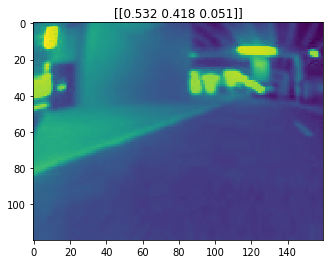

In [103]:
viz_layer_output(img=x[4], layer_idx=5, pred_idx=0, model=model)